In [1]:
from ModelResult import ModelResult
import matplotlib.pyplot as plt
import numpy as np

Setup a model group for CanESM5 where the groups are based on which `1pctCO2` variant present in the filename.

In [2]:
m = ModelResult("/home/nate/data/ILAMB/MODELS/1pctCO2/CanESM5",name="CanESM5")
m.findFiles(group_regex=".*_(.*)_r1i1p1f1*")
print(m)

ModelResult: CanESM5
--------------------
  + 1pctCO2
  + 1pctCO2-bgc
  + 1pctCO2-rad



Extract the carbon variables we will need. In this case we do not need a multimodel mean and so we leave the keyword `mean` to its default `False`. For these fluxes we will accumulate the global total over the time period.

In [ ]:
nbp   = m.getVariable(  "nbp")
fgco2 = m.getVariable("fgco2")
for key in nbp.keys():
    nbp  [key] = nbp  [key].integrateInSpace().accumulateInTime().convert("Pg")
    fgco2[key] = fgco2[key].integrateInSpace().accumulateInTime().convert("Pg")

We also require the temperature over the time period. Given that temperature is not accumulated and varies throughout a year, we will coarsen it to the mean global annual temperature.

In [ ]:
tas = m.getVariable("tas")
y0,yf = np.round(nbp['1pctCO2'].time_bnds[[0,-1],[0,1]]/365)
years = np.asarray([np.arange(y0,yf),np.arange(y0+1,yf+1)]).T * 365. 
for key in nbp.keys():
    tas[key] = tas[key].integrateInSpace(mean=True).coarsenInTime(years)

To help interpret results and confirm that I have read the variables correctly, we show the trajectories of all 3 variables for each scenario below.

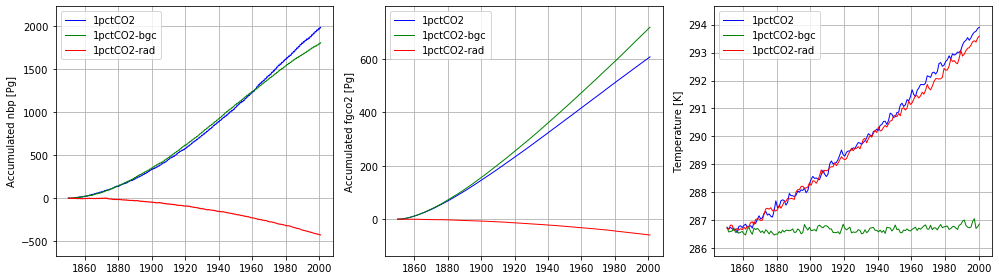

In [43]:
def setLimits(ax,v):
    vmin = 1e20; vmax = -1e20
    for key in v:
        vmin = min(vmin,v[key].data.min())
        vmax = max(vmax,v[key].data.max())
    dv = 0.1*(vmax-vmin)
    vmax += dv; vmin -= dv
    ax.set_ylim(vmin,vmax)
clr = {'1pctCO2':'b','1pctCO2-bgc':'g','1pctCO2-rad':'r'}
fig,ax = plt.subplots(figsize=(14,4),ncols=3,tight_layout=True)
for i,key in enumerate(nbp.keys()):
    nbp  [key].plot(ax[0],color=clr[key],label=key)
    fgco2[key].plot(ax[1],color=clr[key],label=key)
    tas  [key].plot(ax[2],color=clr[key],label=key)
setLimits(ax[0],nbp)
setLimits(ax[1],fgco2)
setLimits(ax[2],tas)
for i in range(3): ax[i].legend(loc=2)
ax[0].set_ylabel("Accumulated nbp [Pg]")
ax[1].set_ylabel("Accumulated fgco2 [Pg]")
ax[2].set_ylabel("Temperature [K]")
plt.show()

Now we compute the changes in carbon and climate and store these in dictionaries where the keys will be the `1pctCO2` variant which corresponds to the data. `dL` is for the change in carbon over land, `dO` is for the change over ocean, and `dT` is the change in temperature.

In [42]:
dL = {}; dO = {}; dT = {}
for key in   nbp: dL[key] =   nbp[key].data[-1]-  nbp[key].data[0]
for key in fgco2: dO[key] = fgco2[key].data[-1]-fgco2[key].data[0]
for key in   tas: dT[key] =   tas[key].data[-1]-  tas[key].data[0]

$\beta$ and $\gamma$ are defined using equations (2-5) of (Friedlingstein 2006)

$$
\begin{align*}
\Delta C_L^c &= \beta_L \Delta C_A^c + \gamma_L \Delta T^c\\
\Delta C_O^c &= \beta_O \Delta C_A^c + \gamma_O \Delta T^c\\
\Delta C_L^u &= \beta_L \Delta C_A^u\\
\Delta C_O^u &= \beta_O \Delta C_A^u
\end{align*}
$$

where the suberscripts $^{c}$ and $^{u}$ refer to *coupled* and *uncoupled*, subscripts $_A$, $_L$, and $_O$ refer to atmosphere, land, and ocean respectively. The changes in land and ocean carbon are taken as the differences in `dL` and `dO`, respectively. The change in atmospheric carbon we compute by using the knowledge that these simulations are run with a 1% annual increase in carbon ($r=0.01$). The carbon after 1 year is,

$$
C_{A,1} = C_{A,0} (1+r)
$$

So the change in carbon after $n$ years is:

$$
\Delta C_A = C_{A,0} ((1+r)^n-1)
$$

If $C_{A,0}=285$ [ppm] and we run from 1850 through 2000, then the change in carbon can be computed directly.

In [46]:
C0 = 285. # [ppm]
r  = 0.01 # [1]
n  = yf-y0
dA = C0*((1+r)**n-1)
print(dA)

995.4785306222518


As per what I understood from Forrest, we compute the $\beta$ terms using the `1pctCO2-bgc` data.

In [49]:
betaL = dL['1pctCO2-bgc']/dA
betaO = dO['1pctCO2-bgc']/dA
print(betaL,betaO)

1.8140997055246295 0.7226848840590298


Then I understood that we use these $\beta$ terms with the `1pctCO2-rad` runs to compute the $\gamma$ terms.

In [50]:
gammaL = (dL['1pctCO2-rad']-betaL*dA)/dT['1pctCO2-rad']
gammaO = (dO['1pctCO2-rad']-betaO*dA)/dT['1pctCO2-rad']
print(gammaL,gammaO)

-325.0497545549327 -113.22136267795995


These do not look right to me, but I really do not understand completely what I am doing. Also, if this is the case, we aren't using `1pctCO2` data at all, just the `-bgc` and `-rad` variants. Is this correct?